### Spectral Energy Distributions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from scipy import optimize
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value
from astropy import units

In [3]:
import notebook_utils
import fit_agn_sed
import ezgal_wrapper
import star_formation

/Data/repos/find_agn/notebook_utils.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/data/miniconda3/envs/find_agn/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/data/miniconda3/envs/find_agn/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in s

In [4]:
df = pd.read_csv('sample_sdss.csv', sep=' ')

In [5]:
df.head()

,lambda,flux,err,tem
0,3637.390,0.314,0.000,54.029
1,3638.227,0.717,0.000,53.619
2,3639.065,1.482,0.000,52.849
3,3639.903,0.798,7.011,53.527
4,3640.741,0.506,7.032,56.245


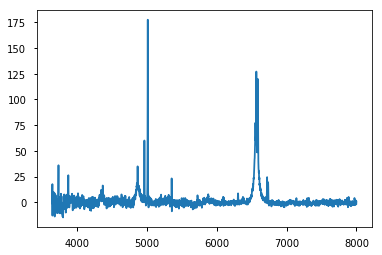

In [6]:
plt.plot(df['lambda'], df['flux'])

In [7]:
new_model_download = False
if new_model_download:
    !wget -r http://www.baryons.org/ezgal/models/index.html
    # OR for single models:
    # !wget http://www.baryons.org/ezgal/models/$target_model -O $target_loc

In [8]:
bpt_df = pd.read_csv('bpt_df.csv')

The goal is to make a probabilistic estimate the AGN and host SEDs, assuming that most galaxies are truly composite.

If the models are simple, or can be made simple, I can fit them to photometry directly.

If not, I might need to use a template catalog.

In [9]:
seyferts = bpt_df[bpt_df['seyfert']]
starforming = bpt_df[bpt_df['starforming']]

###  What SED do we observe?

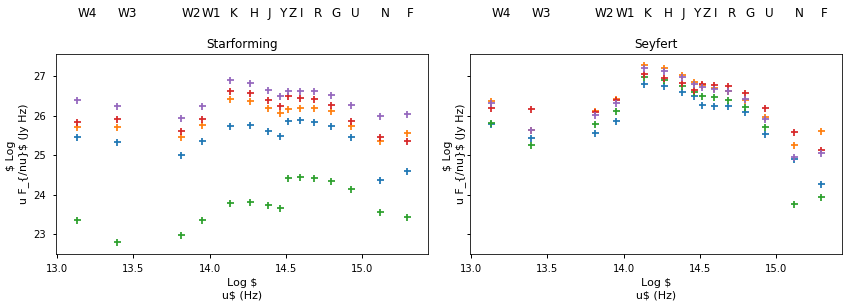

In [10]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4), sharex=True, sharey=True)
for n in range(5):
    starforming_data = notebook_utils.get_spectral_energy(starforming.iloc[n])
    notebook_utils.plot_spectral_energy(starforming_data, ax0)
    
    seyfert_data = notebook_utils.get_spectral_energy(seyferts.iloc[n])
    notebook_utils.plot_spectral_energy(seyfert_data, ax1)
                         
notebook_utils.add_band_labels(starforming_data, ax0)
notebook_utils.add_band_labels(seyfert_data, ax1)
ax0.set_title('Starforming')
ax1.set_title('Seyfert')
fig.tight_layout()

TODO crucially important to add error bars

TODO can ultimately use the optical spectra, not just photometry

### What contribution do AGN make to the SED?

![agn sed](figures/agn_sed_schematic.png)

I'm probing the tail of the accretion disk (optical) and the dusty torus (MIR), overlapping in NIR

Figure in Annual Review, adapted from Harrison, C. M. (2016). Introduction (pp. 1–35). https://doi.org/10.1007/978-3-319-28454-5_1

> it should be noted that the relative contribution of these components can vary dramatically for different types of AGN

>  high-accretion rate AGN that emit most of their energy radiatively (sometimes called “radiatively efficient”, “radiative mode” or, when referring to radio galaxies, “high excitation”; see review in Heckman and Best 2014) and that are radio quiet.4 This thesis does not focus on radiatively-inefficient AGN (sometimes called “low excitation”, “radio mode” or “jet mode”) that emit the majority of their energy mechanically through radio jets 

With BPT, I am selecting radiative mode AGN.

From Best and Heckman 2014 Review:

> {Two AGN types. The first is powered by] efficient conversion of the potential energy of the gas accreted by the SMBH...radiative-mode AGNs. The second category consists of objects that produce relatively little radiation and whose primary energetic output takes the form of the bulk kinetic energy transported in two-sided collimated outflows (jets).

> The ionizing radiation from the disk and corona heats and photoionizes a population of dense gas clouds located on scales of light-days to light-years from the SMBH leading to the production of UV-, optical-, and near-IR-permitted emission lines [Ed: BPT is NOT looking for these lines]

> On larger scales, the SMBH and accretion disk are surrounded by a region of dusty molecular gas...Its inner radius is set by the sublimation temperature of the most refractory dust grains and is hence larger in more luminous AGNs. In this region some of the incident UV/visible photons from the accretion disk and the soft X-rays from the corona are absorbed by the dust, and this absorbed energy emerges as thermal IR emission...As ionizing radiation escapes along the polar axis of the obscuring structure, it photoionizes gas on circumnuclear scales (a few hundred to a few thousand parsecs). This more quiescent and lower-density population of clouds produces UV-, optical-, and IR-forbidden and -permitted emission lines, Doppler-broadened by several hundred kilometers per second, and is hence called the narrow-line region (NLR).

> When observing an AGN from a sight line nearer the equatorial plane of the obscuring structure, this central region is hidden and these are called Type 2 (or obscured) AGNs

This paper has recently done, properly, what I'm hoping to do with SED decomposition: Zhuang, M.-Y., Ho, L. C., & Shangguan, J. (2018). The Infrared Emission and Opening Angle of the Torus in Quasars. Retrieved from http://arxiv.org/abs/1806.03783. They're interested in careful modelling to investigate the torus.

> the bulk of
the mid-IR emission of AGNs actually arises from a polar-extended component, which dominates the energy output in that band, while the near-IR emission still emanates from a classical, small-scale disk-like compo- nent. This discovery radically alters the traditional view of a single torus structure

> We apply these newly developed models to investigate
the physical properties of the torus...We use our recently developed Bayesian Markov Chain Monte Carlo (MCMC) method to decompose the SEDs into their main constituent components, paying special em- phasis on evaluating the performance of the latest spec- tral templates for the AGN torus

Much of the work that they've done is based on:  Shangguan, J., Ho, L. C., & Xie, Y. (2018). On the Gas Content and Efficiency of AGN Feedback in Low-redshift Quasars. The Astrophysical Journal, 854(2), 158. https://doi.org/10.3847/1538-4357/aaa9be

> With a newly developed Bayesian Markov Chain Monte Carlo fitting method, we decompose various overlapping contributions to the integrated spectral energy distribution, including starlight, warm dust from the torus, and cooler dust on galaxy scales. 

Both papers use pretty much the same models for the various AGN and host components...

**CLUMPY**

> For the dust torus emission, we incorporate the templates generated by the radiative transfer model CLUMPY (Nenkova et al. 2008a, 2008b).

[CLUMPY](https://www.clumpy.org/) provides an extensive library of templates for dusty torus emission. 

> The CLUMPY model has seven free parameters: the optical depth of the individual cloud τV, the power-law index q of the cloud radial distribution, the ratio Y of outer and inner radii of the dust torus,14 the average number of clouds on the equatorial ray N0, the standard deviation σ of the Gaussian distribution of the number of clouds in the polar direction, the observer’s viewing angle i from the torus axis, and the luminosity L normalization factor. 

**BB**

Shangguan and others add a hot blackbody to the MIR to get a good fit - see Shangguan equation 1.

**EzGal**

> The stellar emission is represented by a simple stellar population model from **Bruzual & Charlot (2003, hereafter BC03)** with a Chabrier (2003) stellar IMF. We use the Python package **EzGal (Mancone & Gonzalez 2012)** to generate the template spectra. 

**DL07**

> The galactic dust emission is described by the widely used
DL07 model. The model is based on the dust composition and size distribution observed in the Milky Way (MW)...DL07 [provide](https://www.astro.princeton.edu/~draine/dust/irem.html) the precalculated pq U,
n ()() 0 PAH min and pν?(qPAH, Umin, Umax, α) as model
templates.

> By studying the SEDs of normal star-forming galaxies, Draine et al. (2007) found that, for all situations, we can fix α?=?2 and Umax?=?106. We adopt this simplification

I do not include a radio synchrotron component.

The templates provide the forward model: given some parameters, what SED (components) do I get. With templates, this step is completely deterministic - they're simply a grid of pre-calculated values.

In [11]:
sample_galaxy = bpt_df.iloc[0]

In [12]:
ref_exponential = star_formation.exponential_sfh(tau=1.)

In [13]:
target_model = '{}_{}_z_{}_{}.model'.format('bc03', 'ssp', '0.02', 'salp')
model_download_loc = 'catalogs/' + target_model
model = ezgal_wrapper.get_model(model_download_loc, ref_exponential)
formation_z = 3.0
# current_z = sample_galaxy['z'] TODO add
current_z = 0.05
mass = sample_galaxy['ELPETRO_MASS']
fake_galaxy = ezgal_wrapper.get_fake_galaxy(model, formation_z, current_z, mass)

catalogs/bc03_ssp_z_0.02_salp.model


/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/scipy/integrate/quadrature.py:326: RuntimeWarning: divide by zero encountered in true_divide
  h0divh1 = h0 / h1
/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/scipy/integrate/quadrature.py:328: RuntimeWarning: divide by zero encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/scipy/integrate/quadrature.py:329: RuntimeWarning: invalid value encountered in add
  y[slice2]*(2-h0divh1))
/data/repos/find_agn/easyGalaxy/ezgal/cosmology.py:185: RuntimeWarning: divide by zero encountered in log10
  return 5. * num.log10(self.Dl(z) / self.pc / 10)


In [14]:
model_continuum = ezgal_wrapper.get_normalised_model_continuum(model, fake_galaxy)
discrete_sed = notebook_utils.get_spectral_energy(fake_galaxy)

In [17]:
def plot_template(discrete_sed, continuum):

    fig, ax = plt.subplots(figsize=(8, 4), sharex=True, sharey=True)

    ax.plot(np.log10(continuum['frequency']),  np.log10(continuum['energy_density']), 'r', alpha=0.3)  # shifted way down for some reason
    notebook_utils.plot_spectral_energy(discrete_sed, ax=ax)

    ax.legend(['Fake SED', 'Fake Observed Flux'])
    notebook_utils.add_band_labels(discrete_sed, ax=ax, y=17)
    fig.tight_layout()

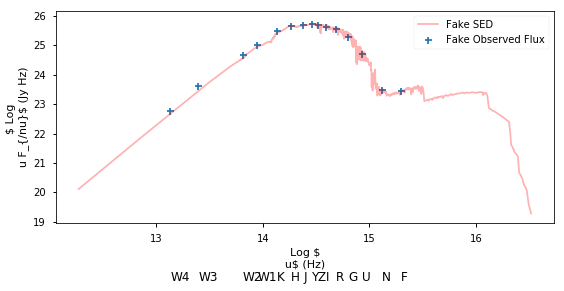

In [18]:
plot_template(discrete_sed, model_continuum)

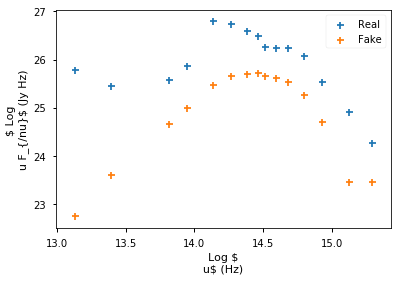

In [21]:
real_data = notebook_utils.get_spectral_energy(seyferts.iloc[0])

fig, ax = plt.subplots()
notebook_utils.plot_spectral_energy(real_data, ax)
notebook_utils.plot_spectral_energy(discrete_sed, ax)
ax.legend(['Real', 'Fake'])

gaussian_scale_a: 0.3821934434704673
gaussian_skew_a: 1.4424939475724414
shift_for_gaussian_a: 5.610172578050789
gaussian_scale_b: 0.2894916400026148
gaussian_skew_b: 1.0559615197987908
shift_for_gaussian_b: 5.026627159817576


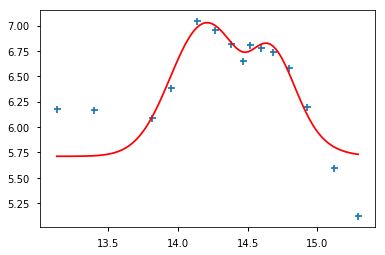

In [24]:
# data to fit
# sed = notebook_utils.get_spectral_energy(starforming.iloc[0])
sed = notebook_utils.get_spectral_energy(seyferts.iloc[3])

freq = np.log10(sed['frequency'])
energy = np.log10(sed['energy']) - 20

best_fit = fit_agn_sed.fit_agn_model_to_spectral_data(freq, energy)

shift_for_host: -8.273830974658996


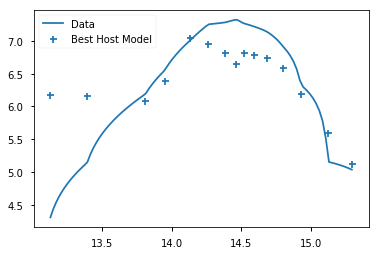

In [25]:
# data to fit
# sed = notebook_utils.get_spectral_energy(starforming.iloc[0])
sed = notebook_utils.get_spectral_energy(seyferts.iloc[3])

log_freq = np.log10(sed['frequency'])
log_energy = np.log10(sed['energy']) - 20

_ = fit_agn_sed.fit_host_model_to_spectral_data(log_freq, log_energy)

gaussian_scale_a: 0.3822534885747911
gaussian_skew_a: 1.442681329909489
shift_for_gaussian_a: 5.610274510036825
gaussian_scale_b: 0.28949559684041243
gaussian_skew_b: 1.0569520524879976
shift_for_gaussian_b: 5.026108379732726
shift_for_host: -12.316004751387803


/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 1600.
  warnings.warn(errors[info][0], RuntimeWarning)


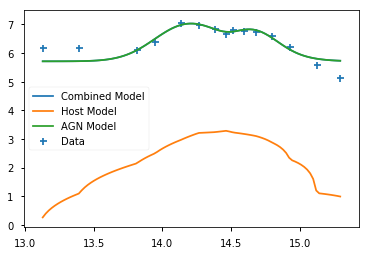

In [26]:
# data to fit
# sed = notebook_utils.get_spectral_energy(starforming.iloc[0])
sed = notebook_utils.get_spectral_energy(seyferts.iloc[3])

log_freq = np.log10(sed['frequency'])
log_energy = np.log10(sed['energy']) - 20  # keep the energy numbers reasonable

_ = fit_agn_sed.fit_composite_model_to_spectral_data(log_freq, log_energy)


Mullaney, J. R., Alexander, D. M., Goulding, A. D., & Hickox, R. C. (2011). Defining the intrinsic AGN infrared spectral energy distribution and measuring its contribution to the infrared output of composite galaxies. Monthly Notices of the Royal Astronomical Society, 414(2), 1082–1110. https://doi.org/10.1111/j.1365-2966.2011.18448.x

> Looked at 11 moderate luminosity $L_{2−10 keV} ∼ 10^{42}–10^{44} erg s^{−1} $ AGN with minimal IR host contamination

> Between 6–100 µm...the average infrared SED of typical AGNs is best described as a broken power law at ?40µm that falls steeply at ?40 µm (i.e. at far-infrared wavelengths).

> to identify a sample of galaxies whose infrared out-
put is dominated by a moderate-luminosity AGN, we cross-match the Swift-BAT samplewith the archive of low-resolution spectra ob- tained by the infrared spectrograph (hereafter IRS) on board Spitzer...we quantify the con- tribution of the host galaxy to theseMIRspectra using the equivalent
widths of the 11.25-µm PAH feature

Sadly, this requires IR spectroscopy - which is not available to me?

> strongly AGN dominated systems have EW PAHλ11.25 < 0.03µm, corresponding to a <10 per cent host-galaxy contribution at 19 µm(see

> infrared spectra...dominated by a featureless AGN continuum
                                                                                                                               
                                                                                                                               > ∼6–20 µm. At these wavelengths, all the 25 AGN- dominated SEDs show clear evidence of a continuous, underlying
power-law continuum that is thought to be produced by multiple dust components spanning a range of temperatures (e.g. Buchanan et al. 2006). The spectral indices of the underlying AGN power-law continua
span the range 0.7 ≤ α1 ≤ 2.7 (mean, α1 = 1.6)

>In at least 20 of the 25 AGN-dominated MIR spectra there is a definite break in the power-law continuum at 15–20 µm; the
mean break position is at ∼19 µm. In previous studies this has been attributed to a dominatingwarm (i.e.∼170 K) dust component that is heated by the AGN...where we see a break in the continuum power law, the AGN SED longward of λBrk has a lower spectral
index (i.e. power-law index, 0 ≤ α2 ≤ 1.5, mean = 0.7

I should put the AGN models aside for now and just like at how much star formation can be going on.

I should review the Ellison 2016 paper that gets Lir from Ellison NN and aim to replicate the plot of star formation (from Lir) vs num galaxies hist, for different AGN selection - but in my case, for plausible AGN LOIII as well. Slider!

I should use an EZGAL BC03 or derivative model (M is wrong), with an old (>5Gyr) population and a current burst. BPT measures current SF, remember.


I need a link between L[OIII] and star formation. There are empirical scaling relations for star formation -> L[OIIII], and there might also be extractable lines from the SED models.

For later, it might be really interesting to look at independent SF probes. Look at ALFAFA - radio survey of HI in many sloan galaxies.

### EZGAL models of old population + new bursty population

In [27]:
sample_galaxy = starforming.iloc[0]

In [92]:
ezgal_model_dir = 'models/ezgal_models'

reference_model_loc = 'models/ezgal_models/bc03_ssp_z_0.05_salp.model'  # ssp will be overridden

model_loc = reference_model_loc
# model_loc = os.path.join(ezgal_model_dir, '{}_{}_z_{}_{}.fits'.format(modelset, sfh, met, imf))

Define an arbitrary star formation history: See [here](http://www.baryons.org/ezgal/manual/modifying_models.html)

In [93]:
def formation_redshift_for_fixed_age(current_z, current_galaxy_age):
    universe_age_at_current_redshift = cosmo.age(current_z)
    assert universe_age_at_current_redshift > 12 * units.Gyr
    universe_age_at_formation_redshift = universe_age_at_current_redshift - current_galaxy_age
    assert universe_age_at_formation_redshift < 6 * units.Gyr
    formation_z = z_at_value(cosmo.age, universe_age_at_formation_redshift)
    assert formation_z > 1
    return formation_z

In [94]:
# To minimise saved model grid dimensions, 
# make all galaxies the same age: 8 Gyr from formation
current_galaxy_age = 8 * units.Gyr
current_z = 0.05  # defined to be here, very small error introduced
formation_z = formation_redshift_for_fixed_age(current_z, current_galaxy_age)

In [95]:
first_duration = 1.  # Gyr
second_duration = .5  # Gyr
dual_burst = star_formation.dual_burst_sfh(
        current_z=current_z,
        formation_z=formation_z, 
        first_duration=first_duration, 
        second_duration=second_duration)

#### Calculate model and save outputs (galaxy, continuum) in lookup table

In [96]:
save_dir = 'saved_templates'

In [97]:
new_model = True
if new_model:
    model = ezgal_wrapper.get_model(model_loc, dual_burst)  # 15 mins to calculate
    mass = 1.  # do not rescale, leave as 1 Msun stellar population
    # TODO refactor magnitude mass rescaling as separate notebook_utils method
    ezgal_wrapper.save_template(model, save_dir, formation_z, current_z, mass)

models/ezgal_models/bc03_ssp_z_0.05_salp.model


/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/scipy/integrate/quadrature.py:326: RuntimeWa

#### Load galaxy, continuum from lookup table

In [98]:
galaxy, continuum = ezgal_wrapper.load_saved_template(save_dir, formation_z, current_z, mass=1.)

#### Visualise to confirm

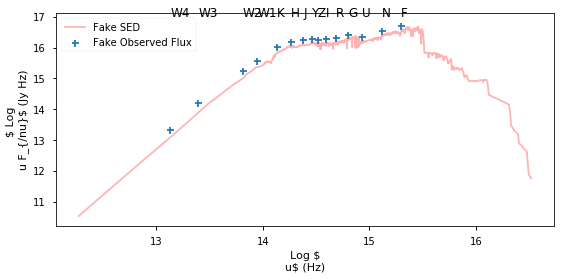

In [99]:
discrete_sed = notebook_utils.get_spectral_energy(galaxy)
plot_template(discrete_sed, continuum)

In [100]:
galaxy['z'] = 0.

In [101]:
continuum = ezgal_wrapper.get_normalised_model_continuum(model, galaxy, observed=True)
rest_continuum = ezgal_wrapper.get_normalised_model_continuum(model, galaxy, observed=False)

/data/repos/find_agn/easyGalaxy/ezgal/cosmology.py:185: RuntimeWarning: divide by zero encountered in log10
  return 5. * num.log10(self.Dl(z) / self.pc / 10)
/Data/repos/find_agn/ezgal_wrapper.py:159: RuntimeWarning: invalid value encountered in add
  'energy_density': 10 ** (np.log10(energy_from_sed) + sed_log_offset)  # add a log shift


In [102]:
spectra = pd.DataFrame(data=rest_continuum)
spectra['wavelength'] = spectra['wavelength'] * 1e10
spectra['log_wavelength'] = np.log10(spectra['wavelength'])
spectra['log_energy'] = np.log10(spectra['energy_density'])


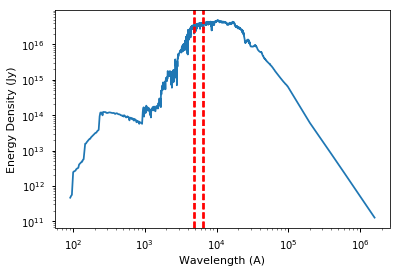

In [103]:
plt.loglog(spectra['wavelength'], spectra['energy_density'])
plt.ylabel('Energy Density (Jy)')
plt.xlabel('Wavelength (A)')
for line in np.array([4861, 5006, 6562, 6583]):
    plt.axvline(line, color='r', linestyle='--')

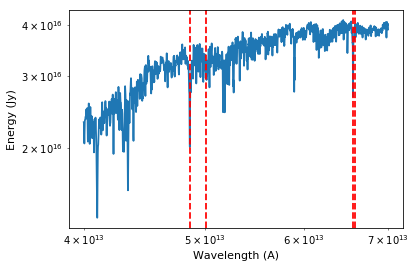

In [104]:
optical_spectra = spectra[
    (spectra['wavelength'] > 4000) &
    (spectra['wavelength'] < 7000)
]
plt.loglog(optical_spectra['wavelength'] * 1e10, optical_spectra['energy_density'])
plt.ylabel('Energy (Jy)')
plt.xlabel('Wavelength (A)')
for line in np.array([4861, 5006, 6562, 6583]) * 1e10:
    plt.axvline(line, color='r', linestyle='--')

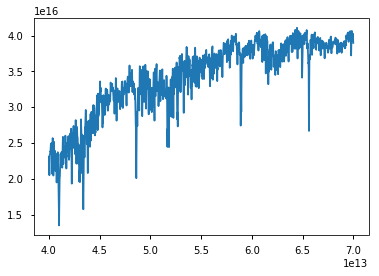

In [105]:
plt.plot(optical_spectra['wavelength'] * 1e10, optical_spectra['energy_density'])

We can definitely fit a smooth polynomial / local regression to the optical background.

In [106]:
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

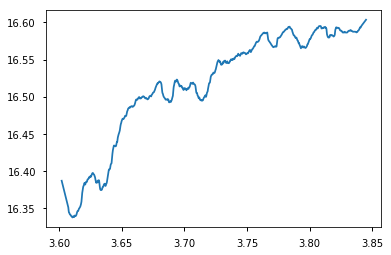

In [107]:
baseline = savgol_filter(np.log10(optical_spectra['energy_density']), 101, 1)
plt.plot(np.log10(optical_spectra['wavelength']), baseline)

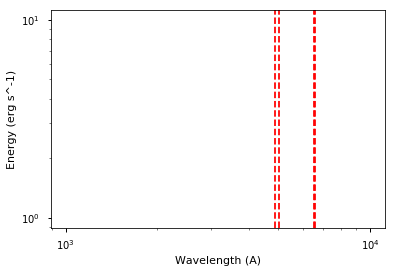

In [108]:
plt.loglog(continuum['wavelength'] * 1e10, continuum['energy_density'])
plt.ylabel('Energy (erg s^-1)')
plt.xlabel('Wavelength (A)')
for line in [4861, 5006, 6562, 6583]:
    plt.axvline(line, color='r', linestyle='--')

In [109]:
plot_width = 20

lO3_spectra = spectra[  # 5006
    (spectra['wavelength'] > 5006 - plot_width) &
    (spectra['wavelength'] < 5006 + plot_width)]

hb_spectra = spectra[  # 4861
    (spectra['wavelength'] > 4861 - plot_width) &
    (spectra['wavelength'] < 4861 + plot_width)]

n2_spectra = spectra[  # 6583
    (spectra['wavelength'] > 6583 - plot_width) &
    (spectra['wavelength'] < 6583 + plot_width)]

ha_spectra = spectra[  # 6562
    (spectra['wavelength'] > 6562 - plot_width) &
    (spectra['wavelength'] < 6562 + plot_width)]

In [110]:
plot_width = 20

In [111]:
optical_spectra.to_csv('optical_spectra.csv', index=False)

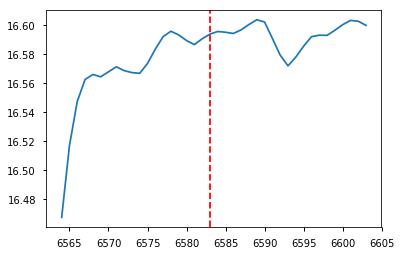

In [127]:
plt.plot(n2_spectra['wavelength'], n2_spectra['log_energy'])
plt.axvline(6583, color='r', linestyle='--')

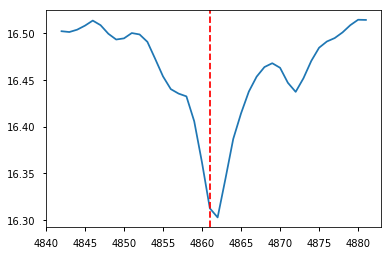

In [124]:
plt.plot(hb_spectra['wavelength'], hb_spectra['log_energy'])
plt.axvline(4861, color='r', linestyle='--')

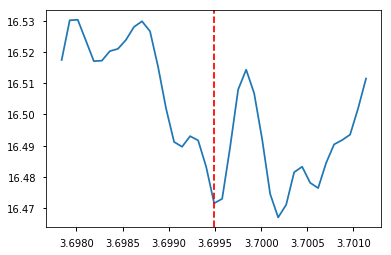

In [125]:
plt.plot(lO3_spectra['log_wavelength'], lO3_spectra['log_energy'])
plt.axvline(np.log10(5006), color='r', linestyle='--')

### Fit model to real SED to derive max and min star formation

### Convert max and min star formation to L[OIII]/Ha, either empirically or (ideally) direct from model

In [ ]:
### Star Formation Estimates

#### SDSS Star Formation Rates

> The techniques used to determine total SFRs for SDSS galaxies are described in detail by Brinchmann et al. (2004) and Salim et al. (2007), but we review the salient details here. The fibre spectra are fit with models from Charlot & Longhetti (2001), which combine stellar continuum templates with emission lines simulated by the CLOUDY software (Ferland et al. 1998). The models are run over large grids of input parameters, including dust attenuation, metallicity and SFR...Although the models fit the entire SDSS spectrum, the derived SFRs are dominated by the strength of the Balmer emission lines. 

> Brinchmann et al. (2004) note that **contributions to emission lines from processes not related to star formation will lead to erroneous SFRs. Such processes include ** shocks, planetary nebulae and **AGN**. Brinchmann et al. (2004) therefore **identify galaxies with either a minor (‘composite’) or dominant AGN contribution using...the diagnostic diagrams of Kewley et al. (2001) and Kauffmann et al. (2003). For both the composite and AGN galaxies, the SFR is determined from the correlation between D4000 and specific SFR (SSFR), as measured in the star-forming population**. 

> Errors on SFRs derived from D4000 are computed by convolving the likelihood distribution of a given galaxy’s D4000 with that of the relation between SSFR and D4000 in star-forming galaxies.

> For all galaxy classes, the ‘fibre’ SFRs are converted to total SFRs by assessing the photometry outside of the aperture. [Ed: this is hopefully explained in more detail in Brinchmann]

#### NN Star Formation Rates

Ellison aims to estimate the **total** IR (6 - 1000 um) luminosity based on (among other features) Herschel FIR, WISE NIR, total stellar mass, fibre stellar mass, D4000, and the **BPT emission lines**.

The ground truth comes from fitting any available photometry to galaxy templates, and then integrating over those templates to get total $L_{IR}$

> The mid-IR and FIR photometry of galaxies from WISE and each of the FIR surveys described above, respectively, were fit with the galaxy spectral energy distribution (SED) templates of Dale &Helou (2002)

> integrating the best-fitting templates over rest frame 8– 1000 µm.

This is not quite ideal for me - I already have NIR and MIR from UKIDSS and WISE. 

Given an inferred $L_{IR}$:
> We adopt the conversion between LIR and SFR from Kennicutt (1998), with an adjustment for a Chabrier initial mass function (IMF):
>
> log $L_{IR}$ = log SFR + 43.591

> The SFRs
inferred from the ANN LIR predictions are in excellent agreement with SDSS spectroscopic SFRs for star-forming galaxies. However, for the AGN with LIR predictions, the SDSS SFR is apparently underestimated by up to an order of magnitude, even when the uncertainty threshold has been imposed. It is demonstrated that this apparent underestimate is due to larger uncertainties in the SDSS SFRs forAGNgalaxies, which are based on D4000, and the detection
threshold in the training set. The LIR predictions provided here can therefore be used to obtain more accurate SFR measurements in AGN, or in weak emission galaxies where there exist large uncer- tainties in the SDSS derived values

In [129]:
def ellison_log_sfr(log_lir):
    return log_lir - 43.591

In [130]:
bpt_df['log_sfr'] = ellison_log_sfr(bpt_df['log_lir'])

In [131]:
# size=600
# show_bpt_colors(bpt_df, 'log_sfr').options(height=size, width=size) * hv.Text(-1, -1, 'Log SFR')

There is a strong mass-metallicity relation which probably explains why this is such a horizontal trend. This is itself quite interesting - heirarchical model can't explain because stars can't know which galaxies they end up in ahead of time! Could be a really interesting probe for something.

In [132]:
# size=600
# show_bpt_colors(bpt_df, 'std_dev').options(height=size, width=size) * hv.Text(-1, -1, 'FIR L Ensemble Std Dev')

Chris:
    - Use an accessible color pallette, AAS has a link on their website
    - Don't add in GZ until we've settled (or at least made a good start on) a model and cuts. Human brains are sensitive.
    - Type 1 and X-ray are for bright AGN, which is not what we want
    - Use the NN Herschel catalog
    
Our unique selling point is looking at LOW luminosity AGN. This is suprisingly unusual. 

If at all possible, find some star formation indicators that are independent of AGN activity. Use this to put a 'max/plausible star formation contribution to OIII' limit (Kewley style) for each galaxy, and therefore a min/plausible AGN contribution.

Use WISE color to put an upper limit on AGN luminosity for galaxies with low OIII, low star formation. Since star formation is low and OIII is low, we can't have an AGN with more than X luminosity.

Use a probability distribution for each classification and hope for the best.

Don't try to do star formation inference 'properly' or extract more derived data than already done by others - these are thesis-scale projects. **Keep the models simple and understandable and do a good job of tracking the errors and statistics**

To share this notebook, use [binder](https://mybinder.readthedocs.io/en/latest/introduction.html#what-technology-does-binder-use)

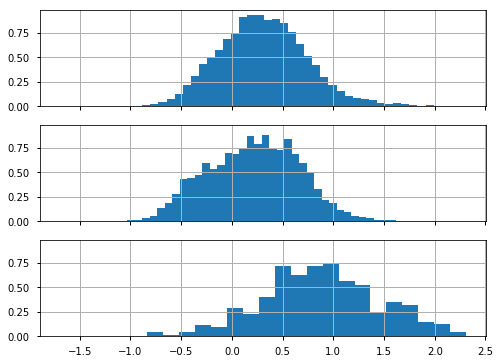

In [133]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 6), sharex=True, sharey=True)
bpt_df[bpt_df['galaxy_type'] == 'seyfert']['log_sfr'].hist(bins=50, ax=ax0, density=True)
bpt_df[bpt_df['galaxy_type'] == 'starforming']['log_sfr'].hist(bins=50, ax=ax1, density=True)
bpt_df[bpt_df['WISE_AGN']]['log_sfr'].hist(bins=20, ax=ax2, density=True)

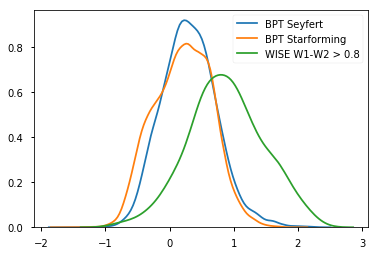

In [134]:
sns.kdeplot(data=bpt_df[bpt_df['galaxy_type'] == 'seyfert']['log_sfr'].dropna(), label='BPT Seyfert')
sns.kdeplot(data=bpt_df[bpt_df['galaxy_type'] == 'starforming']['log_sfr'].dropna(), label='BPT Starforming')
sns.kdeplot(data=bpt_df[bpt_df['WISE_AGN']]['log_sfr'].dropna(), label='WISE W1-W2 > 0.8')

In [135]:
# from compare_agn_with_bar_fraction
def match_distributions_between_catalogs(catalog_to_match, catalog_to_sample, value_col, limits, bw_tuple):
    catalog_to_match_kde = gaussian_kde(catalog_to_match[value_col], bw_method=bw_tuple[0])  # 0.15
    fig, ax = plt.subplots(1, figsize=(8, 3))
    sample_points = np.arange(limits[0], limits[1], 0.001)
    
    ax.plot(sample_points, catalog_to_match_kde.evaluate(sample_points))  # check it's working
    ax.set_xlim([limits[0], limits[1]])

    catalog_to_sample_kde = gaussian_kde(catalog_to_sample[value_col], bw_method=bw_tuple[1])  # it's important to fit the apparent distribution - normalise
    ax.plot(sample_points, catalog_to_sample_kde.evaluate(sample_points))  # check it's working
    
    ax.legend(['catalog to match', 'catalog to sample'])
    
    catalog_to_sample['resample_p'] = catalog_to_match_kde.evaluate(catalog_to_sample[value_col]) / catalog_to_sample_kde.evaluate(catalog_to_sample[value_col])
    catalog_to_sample['resample_p'] = catalog_to_sample['resample_p'] / catalog_to_sample['resample_p'].mean()
    catalog_sampled = catalog_to_sample.sample(len(catalog_to_match), replace=True, weights=catalog_to_sample['resample_p'])
    
    return catalog_sampled

In [136]:
bpt_df['log_mass'] = np.log10(bpt_df['ELPETRO_MASS'])

/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [137]:
bpt_df = bpt_df.replace([np.inf, -np.inf], np.nan)
bpt_df = bpt_df.dropna(how='any', subset=['ELPETRO_MASS', 'log_sfr', 'log_mass', 'z']) 

In [138]:
starforming = bpt_df[bpt_df['galaxy_type'] == 'starforming']
seyfert = bpt_df[bpt_df['galaxy_type'] == 'seyfert']

In [139]:
from scipy.stats import gaussian_kde

/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


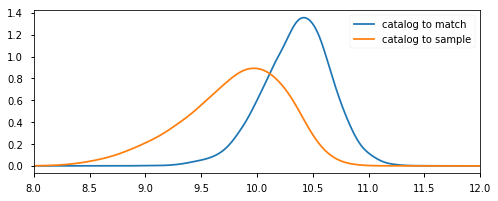

In [140]:
catalog_mass_sampled = match_distributions_between_catalogs(seyfert, starforming, 'log_mass', (8, 12), (.2, .2))

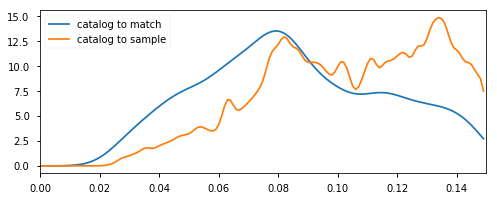

In [141]:
catalog_sampled = match_distributions_between_catalogs(seyfert, catalog_mass_sampled, 'z', (0, 0.15), (.2, .05))

In [142]:
def visualise_match_quality(catalog_to_match, catalog_to_sample, sample, names, bw_mass, bw_colour, bw_redshift):
    fig, axes = plt.subplots(3, 1, figsize=(8, 9))
    lerg_mass_ax = sns.kdeplot(data=catalog_to_match['log_mass'], shade=True, bw=bw_mass, ax=axes[0], legend=False)
    ax = sns.kdeplot(data=catalog_to_sample['log_mass'], shade=True, bw=bw_mass, ax=axes[0], legend=False)
    ax = sns.kdeplot(data=sample['log_mass'], shade=True, bw=0.15, ax=axes[0], legend=False)
    lerg_mass_ax.set_title('mass')
    lerg_mass_ax.legend(names)

#     ax = sns.kdeplot(data=catalog_to_match['g-r'], shade=True, bw=bw_colour, ax=axes[1], legend=False)
#     ax = sns.kdeplot(data=catalog_to_sample['g-r'], shade=True, bw=bw_colour, ax=axes[1], legend=False)
#     ax = sns.kdeplot(data=sample['g-r'], shade=True, bw=bw_colour, ax=axes[1], legend=False)
#     ax.legend(names)
#     ax.set_title('colour')

    ax = sns.kdeplot(data=catalog_to_match['z'], shade=True, bw=bw_redshift, ax=axes[2], legend=False)
    ax = sns.kdeplot(data=catalog_to_sample['z'], shade=True, bw=bw_redshift, ax=axes[2], legend=False)
    ax = sns.kdeplot(data=sample['z'], shade=True, bw=bw_redshift, ax=axes[2], legend=False)
    ax.legend(names)
    ax.set_title('redshift')
    
    fig.tight_layout()

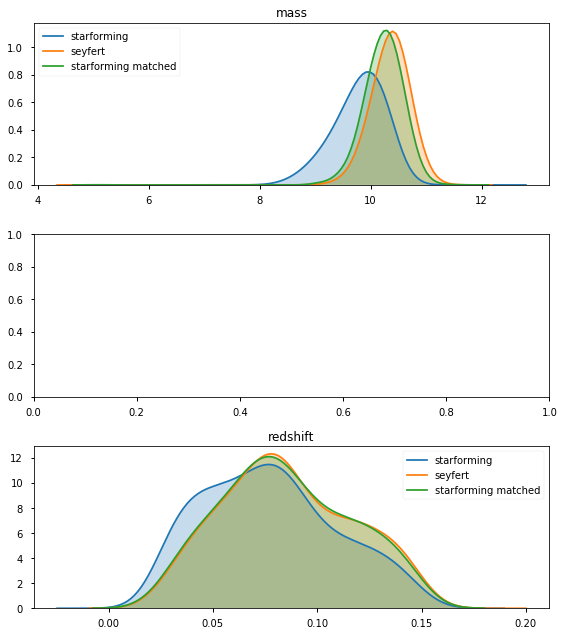

In [154]:
names = ['starforming', 'seyfert', 'starforming matched']
visualise_match_quality(starforming, seyfert, catalog_sampled, names, .2, .2, .01)

In [144]:
starforming_matched_to_seyfert = catalog_sampled


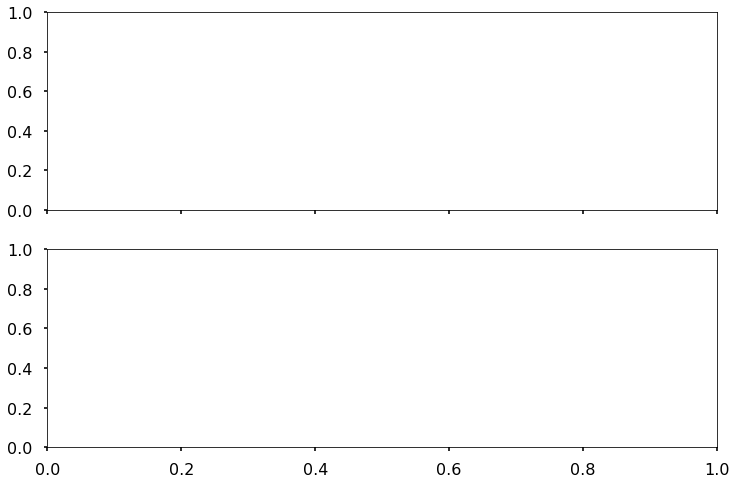

In [178]:
sns.set_context('poster')
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True, sharey=True)

In [181]:
sns.kdeplot(data=seyfert['log_sfr'], label='BPT Seyfert', ax=ax0)
sns.kdeplot(data=starforming_matched_to_seyfert['log_sfr'], label='Starforming like Seyfert', ax=ax0)

In [146]:
wise = bpt_df[bpt_df['WISE_AGN']]

/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


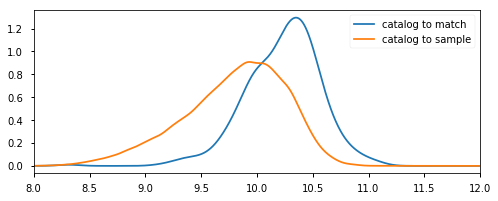

In [147]:
sf_mass_sampled_to_wise = match_distributions_between_catalogs(wise, starforming, 'log_mass', (8, 12), (.3, .1))

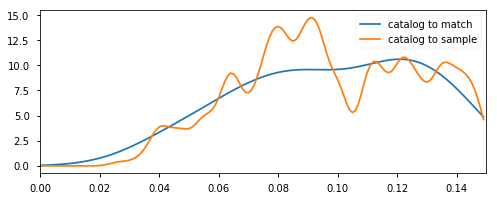

In [148]:
sf_sampled_to_wise = match_distributions_between_catalogs(wise, sf_mass_sampled_to_wise, 'z', (0, 0.15), (.4, .1))

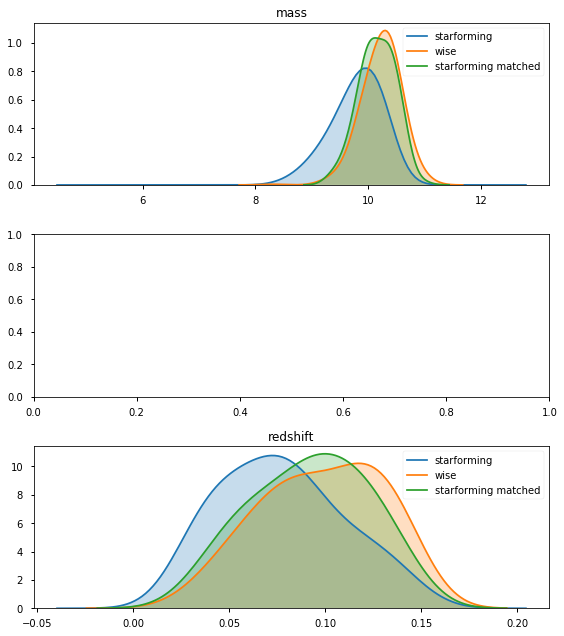

In [161]:
names = ['starforming', 'wise', 'starforming matched']
visualise_match_quality(starforming, wise, sf_sampled_to_wise, names, .2, .2, .015)

In [179]:
sns.kdeplot(data=wise['log_sfr'].dropna(), label='WISE W1-W2 > 0.8', ax=ax1)
sns.kdeplot(data=sf_sampled_to_wise['log_sfr'], label='Starforming like WISE', ax=ax1)

In [182]:

ax0.set_ylabel('Galaxy PDF')
ax1.set_xlabel('Log SFR (NN FIR estimate)')
fig.tight_layout()
fig.savefig('bpt_wise_star_formation_comparison.png')

In [183]:
fig.show()

/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
